In [3]:
from db_utils.db_utils import connect_to_db, load_data
from db_utils.preprocess_data import preprocess_data
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt

## Loading and transforming data

In [8]:
try:
    conn_mw, cursor_mw = connect_to_db()
    df = load_data(
        cursor_mw, 'SELECT * FROM "HistoricalElectricityWeather" WHERE price IS NOT NULL')
    print('load data = ', df.shape)
    df_processed = preprocess_data(df)
    print('processed data', df_processed.shape)
    cursor_mw.close()
    conn_mw.close()
except Exception as e:
    print(f'Exception occured - {e}')

Database connection established
Data was loaded
load data =  (22246, 11)
Data was processed
processed data (22246, 11)


c:\Users\natal\bearit_project\electricity-shoc\algorithm\model\scripts\load_data.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


## Building model

In [9]:
# X - features, y - target variable
X = df_processed.drop(['price', 'id', 'dateId', 'createdDate', 'modifiedDate'], axis=1)
y = df_processed['price']

In [38]:
X.columns

Index(['temperature', 'precipitation', 'cloudCover', 'windSpeed10m',
       'shortwaveRadiation', 'weatherCodeId'],
      dtype='object')

In [11]:
# Normalize features
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)

In [12]:
# Normilize the target
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [13]:
# Save the scalers for further use
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [14]:
# Load the scalers for further use
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

In [15]:
# Split x into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.1, random_state=42)

In [16]:
# Print the shape of the resulting data sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20021, 6)
y_train shape: (20021, 1)
X_test shape: (2225, 6)
y_test shape: (2225, 1)


In [19]:
# Define the model
model = Sequential()

model.add(Dense(60, input_dim=X_normalized.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

c:\Users\natal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [21]:
# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5886 - mean_absolute_error: 0.5804 - val_loss: 0.0111 - val_mean_absolute_error: 0.0896
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0694 - mean_absolute_error: 0.1980 - val_loss: 0.0038 - val_mean_absolute_error: 0.0495
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.1001 - val_loss: 0.0027 - val_mean_absolute_error: 0.0391
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0565 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353
Epoch 5/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0381 - val_loss: 0.0023 - val_mean_absolute_error: 0.0335
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0327 - val_loss: 0.0023 - val_mean_absolute_error: 0.0329
Epoch 7/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0

## Evaluate model

In [22]:
# Extract loss and metric values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

In [23]:
#epochs= 100 lr=0.001 batch=32 hidden layer= 6 validation split = 0.3 with dropouts 0.3 BatchNormalization
print("\n Evaluate the new model against the test set:")
model.evaluate(x=X_train, y=y_train, batch_size=32)


 Evaluate the new model against the test set:
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0020 - mean_absolute_error: 0.0304


[0.0019900635816156864, 0.03061169572174549]

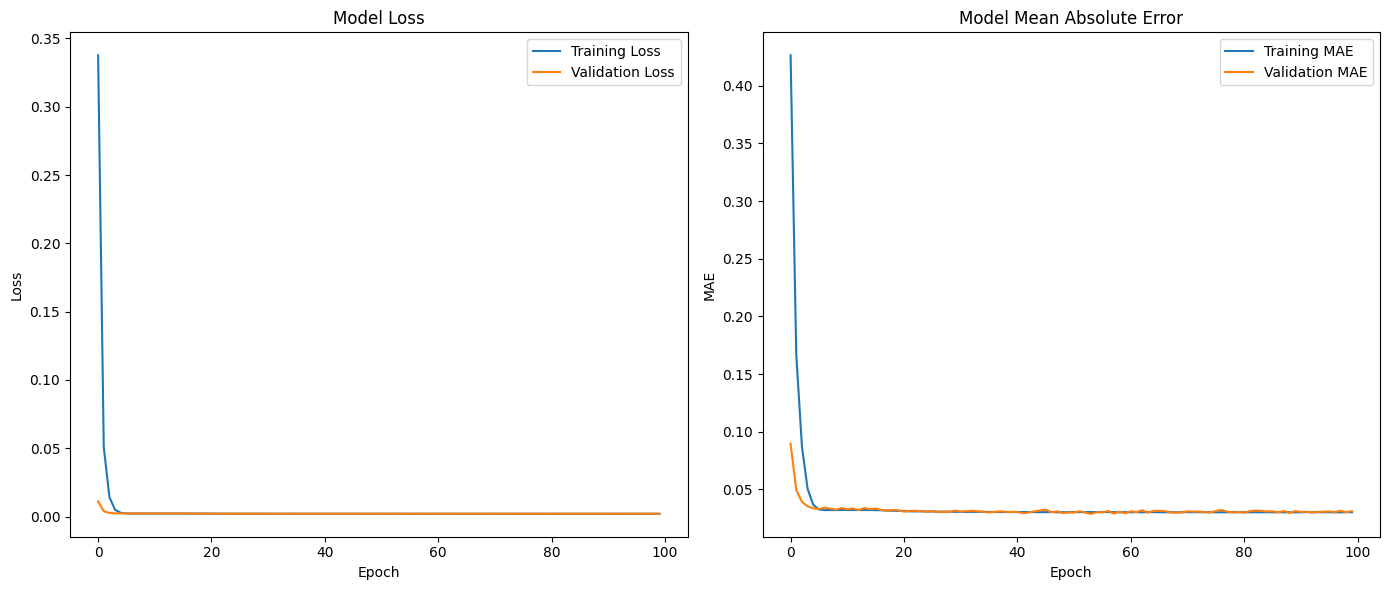

In [24]:
#epochs= 100 lr=0.001 batch=32 hidden layer= 6 validation split = 0.3 with dropouts 0.3 BatchNormalization
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Prediction with X_test

In [26]:
# Predicting with the model
predictions = model.predict(X_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


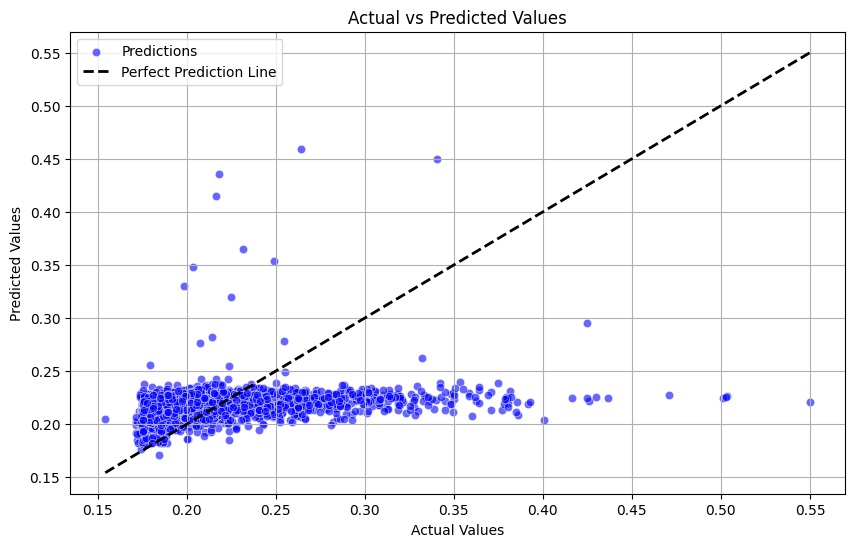

In [27]:
# Scatter Plot of Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Predictions', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

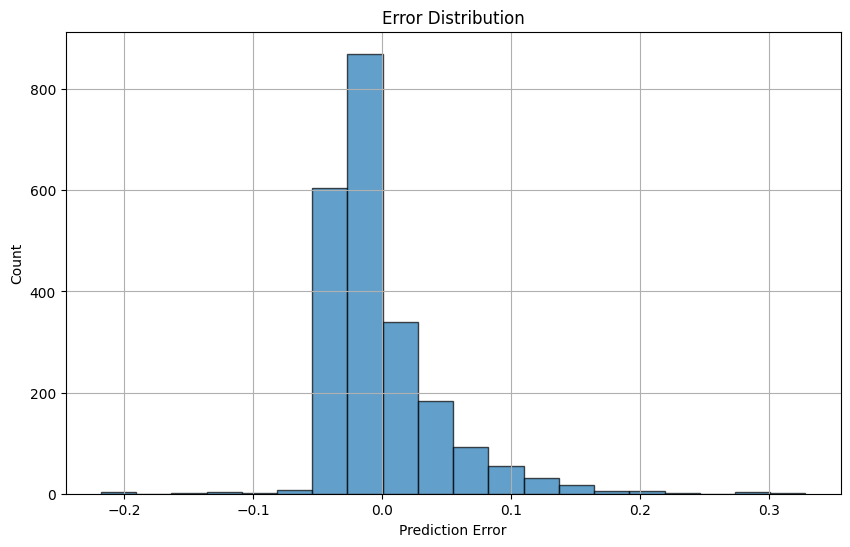

In [28]:
# Calculate the errors
errors = y_test - predictions

# Error Distribution Plot
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.grid(True)
plt.show()

## Inverse to original price values

In [30]:
# Inverse transform the predicted values to get the original scale
y_test_original = scaler_y.inverse_transform(y_test)
pred_original = scaler_y.inverse_transform(predictions)

In [36]:
# Create a DataFrame with prediction and actual value column
output_df = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': predictions.flatten()
})

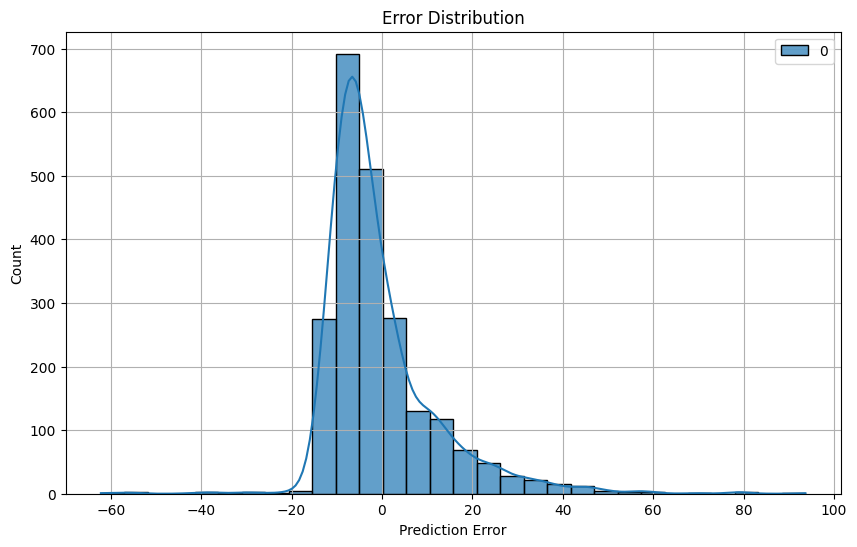

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the errors (assuming pred_original and y_test_original are defined)
errors = abs(y_test_original) - abs(pred_original)

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE plot
sns.histplot(errors, kde=True, bins=30, stat='count', edgecolor='k', alpha=0.7)

# Customize labels and title
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [33]:
# Count the number of predictions with difference of these values
# Calculate the absolute values
y_test_abs = np.abs(y_test_original)
pred_abs = np.abs(pred_original)

# Calculate the differences
difference = y_test_abs - pred_abs

count_1 = np.count_nonzero(difference < 0.2);
count_2 = np.count_nonzero((difference < 0.5) & (difference >= 0.2 ));
count_3 = np.count_nonzero((difference >= 0.5) & (difference < 1.0));
count_4 = np.count_nonzero((difference >= 1) );

print("Number of predictions with difference in less than 0.2 cents:", count_1)
print("Number of predictions with difference in less than 0.5 and more than 0.2 cents:", count_2)
print("Number of predictions with difference in less than 1 euro and more than 0.5 cents:", count_3)
print("Number of predictions with difference in more than 1 euro:", count_4)

Number of predictions with difference in less than 0.2 cents: 1496
Number of predictions with difference in less than 0.5 and more than 0.2 cents: 13
Number of predictions with difference in less than 1 euro and more than 0.5 cents: 32
Number of predictions with difference in more than 1 euro: 684


Model evaluation with two evaluation metrices.


*   The loss value indicates the overall error of the model's predictions compared to the actual values. Lower loss indicates better model performance.
*   The mean_absolute_error (MAE) measures the average magnitude of errors in the predictions, without considering their direction (positive or negative). Lower MAE indicates more accurate predictions.

In [34]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print("Model loss:", loss)
print("Model MAE:", mae)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0020 - mean_absolute_error: 0.0313
Model loss: 0.0018966769566759467
Model MAE: 0.031088490039110184


In [25]:
# Save the model
model.save('electricity_price_model.h5')